<a href="https://colab.research.google.com/github/shlomi1993/deep-learning-notebooks/blob/main/3_autograd.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Deep Learning
# Chapter 3 - Autograd

## Imports

Importing necessary modules. torch is used for all tensor operations. typing is used to define input types more clearly (like tuples or lists), and tqdm is used for progress display when iterating through the loop.

In [1]:
import torch
import math
import matplotlib.pyplot as plt

from typing import Tuple, List, Dict, Union, Optional
from tqdm.notebook import tqdm

## Implement `Multinomial` Function

### Introduction

The task is to implement a function `my_sampler` that gets `size`, `dist`, `requires_grad` parameters and samples integers according to a given discrete probability distribution. This function is a custom implementation for `torch.multinomial`.

The function should return a PyTorch tensor of the specified shape (`size`) containing integers from `0` to `n-1`, where `n` is the length of the distribution dist.

Each integer `i` should be sampled with probability `dist[i]`. The function must validate the input distribution, optionally support gradient tracking, and use only one Python loop, which must begin with `for i in range(len(dist) - 1):`.

Using `torch.multinomial` or similar high-level sampling functions is not allowed.

### Function Definition

The function `my_sampler` accepts three parameters:
- `size` - Determines the shape of the output tensor.
- `dist` - A list of probabilities defining the discrete distribution
- `requires_grad` - A boolean flag indicating whether the returned tensor should track gradients for PyTorch's autograd system.

The function returns a PyTorch tensor filled with integers sampled from the range `[0, len(dist) - 1]` according to the probabilities specified in dist. The returned tensor will have the shape specified by size. If `requires_grad=True` is passed, the tensor will track gradients, enabling it to be used in autograd-based computations.

In [2]:
def my_sampler(size: Union[int, Tuple[int, ...]], dist: List[float], requires_grad: bool = False) -> torch.Tensor:
    # Convert dist to a torch tensor of type float32
    dist_tensor = torch.tensor(dist, dtype=torch.float32)

    # Validate the distribution
    assert torch.all(dist_tensor > 0), "All probabilities must be positive"
    assert torch.abs(dist_tensor.sum() - 1.0) < 1e-6, "Probabilities must sum to 1"

    # Compute cumulative distribution
    cumsum = torch.cumsum(dist_tensor, dim=0)

    # Sample uniform values
    U = torch.rand(size)

    # Allocate tensor for samples
    samples = torch.empty(size, dtype=torch.float32)

    # Loop through the intervals to assign values
    for i in tqdm(range(len(dist) - 1), desc="Assign values"):
        condition = (U >= cumsum[i]) & (U < cumsum[i + 1])
        samples[condition] = float(i + 1)

    # Assign value 0 where U < cumsum[0] and value n where U >= cumsum[-1]
    samples[U < cumsum[0]] = 0.0
    samples[U >= cumsum[-1]] = float(len(dist) - 1)

    # Set requires_grad if requested
    if requires_grad:
        samples.requires_grad_()

    return samples

### Implementation Notes

1. **Converting and balidating the distribution:** The input list `dist` is first converted to a PyTorch tensor with type `float32`. Two assertions are then made: one to ensure all probabilities are strictly positive, and another to ensure their sum is approximately 1 (allowing a small margin of error due to floating-point arithmetic). These checks ensure that the distribution is valid for sampling.

2. **Compute the cumulative distribution:** The cumulative sum of the distribution is computed using the allowed PyTorch function `torch.cumsum`. This is a common method used in inverse transform sampling to define ranges for mapping a uniform random value to one of the discrete classes. For example, with `dist = [0.1, 0.2, 0.7]`, the cumulative distribution would be `[0.1, 0.3, 1.0]`.

3. **Sample uniform random values:** Uniform random values in the range `[0, 1)` are sampled using the allowd PyTorch function `torch.rand` with the given `size`. These values are used to decide which class (0, 1, 2, ...) each sample should be assigned to, based on where the uniform value falls in the cumulative distribution.

4. **Allocate output tensor:** An empty tensor with the same shape is created using the `torch.empty` constructor that I assumed we can use as we need a simple function for tensor allocation, with data type `float32`. This tensor will be filled with the sampled class values in the following steps.

5. **Loop through the cumulative distribution:** A single loop is used to iterate over the distribution intervals, starting from `0` to `len(dist) - 2`, as required by the assignment. For each interval `i`, a condition is checked to see which uniform values fall between `cumsum[i]` and `cumsum[i + 1]`. These positions are then assigned the value `i + 1`, indicating they belong to the corresponding class. This loop fills in all sampled values except for those in the first and last interval, which are handled separately.

6. **Handle edge cases:** The values of the tensor where the uniform random value is less than `cumsum[0]` are assigned the class `0`, since they fall into the first bucket. Similarly, values where the uniform is greater than or equal to `cumsum[-1]` are assigned the highest class index, which is `len(dist) - 1`. This ensures all possible uniform values are properly categorized into discrete class indices.

7. **Set requires grad if needed:** If the `requires_grad` parameter is set to `True`, the output tensor is updated in-place to track gradients using `requires_grad_()`. This is useful in cases where the samples will be part of a computation graph and used in optimization.

8. **Return the sampled tensor:** The completed tensor is returned, containing values sampled according to the specified distribution. Each entry is an integer index from `0` to `len(dist) - 1`, where the frequency of each index matches its corresponding probability in the distribution.

### Tests

The following tests validates:
- Sanity - by checking the assignment given example
- Shapes
- Sample values
- Usage of requires_grad flag
- Appropriate handling of invalid inputs such as negative probabilities or distributions that do not sum to 1.
- Edge cases where the uniform value falls outside the first or last intervals.

###### Test given assignment output example

In [3]:
s = my_sampler(10, [0.5, 0.5])
assert set(s.tolist()).issubset({0.0, 1.0}), "Sample output includes unexpected values"
A = my_sampler((2, 8), [0.1, 0.2, 0.7], requires_grad=True)
assert A.shape == (2, 8), "Shape mismatch in example tensor"
assert A.requires_grad, "Example tensor should require grad"
assert A.grad is None, "Gradient should be None before backprop"
assert set(torch.unique(A).tolist()).issubset([0.0, 1.0, 2.0]), "Unexpected values in sampled tensor"
print("✅ Test passed!")

Assign values:   0%|          | 0/1 [00:00<?, ?it/s]

Assign values:   0%|          | 0/2 [00:00<?, ?it/s]

✅ Test passed!


###### Test correct shape of output

In [4]:
assert my_sampler(5, [0.5, 0.5]).shape == (5,), "Shape mismatch for 1D size"
assert my_sampler((2, 3), [0.1, 0.2, 0.7]).shape == (2, 3), "Shape mismatch for 2D size"
print("✅ Test passed!")

Assign values:   0%|          | 0/1 [00:00<?, ?it/s]

Assign values:   0%|          | 0/2 [00:00<?, ?it/s]

✅ Test passed!


###### Test that sampled values are within valid range

In [5]:
dist = [0.2, 0.3, 0.5]
samples = my_sampler(1000, dist)
assert samples.min().item() >= 0, "Sampled values include values < 0"
assert samples.max().item() <= len(dist) - 1, "Sampled values exceed expected maximum"
print("✅ Test passed!")

Assign values:   0%|          | 0/2 [00:00<?, ?it/s]

✅ Test passed!


###### Test `requires_grad` flag

In [6]:
t = my_sampler((4, 4), [0.1, 0.2, 0.7], requires_grad=True)
assert t.requires_grad, "Tensor should have requires_grad=True"
print("✅ Test passed!")

Assign values:   0%|          | 0/2 [00:00<?, ?it/s]

✅ Test passed!


###### Test that invalid distributions (not summing to 1) raise an error

In [7]:
try:
    my_sampler(10, [0.2, 0.2, 0.2])
    assert False, "Expected AssertionError for invalid sum of probabilities"
except AssertionError as e:
    assert "sum to 1" in str(e), "Wrong error message for invalid sum"
print("✅ Test passed!")

✅ Test passed!


###### Test that negative probabilities raise an error

In [8]:
try:
    my_sampler(10, [0.1, -0.1, 1.0])
    assert False, "Expected AssertionError for negative probability"
except AssertionError as e:
    assert "All probabilities must be positive" in str(e), "Wrong error message for negative values"
print("✅ Test passed!")

✅ Test passed!


###### Test create artificial `U < p0` by using a single sample and mocked dist

In [9]:
torch.manual_seed(0)
dist = [0.9, 0.1]
s = my_sampler(1000, dist)
assert (s == 0).sum() > 800, "Too few zeros — possible failure in U < p0 handling"
print("✅ Test passed!")

Assign values:   0%|          | 0/1 [00:00<?, ?it/s]

✅ Test passed!


###### Test `U >= cumsum[-1]` is handled correctly

In [10]:
dist = [0.3, 0.3, 0.4]
torch.manual_seed(123)
s = my_sampler(10000, dist)
assert (s == 2).sum() > 3000, "Too few 2's — possible failure in U >= cumsum[-1] handling"
print("✅ Test passed!")

Assign values:   0%|          | 0/2 [00:00<?, ?it/s]

✅ Test passed!


### Plot Distribution Histogram

After drawing 10,000 samples from the distribution `[0.1, 0.2, 0.7]`, a we plot a histogram using the allowed `matplotlib.pyplot.hist`. The bin edges are carefully chosen to align with integer values (classes 0, 1, 2).

Assign values:   0%|          | 0/2 [00:00<?, ?it/s]

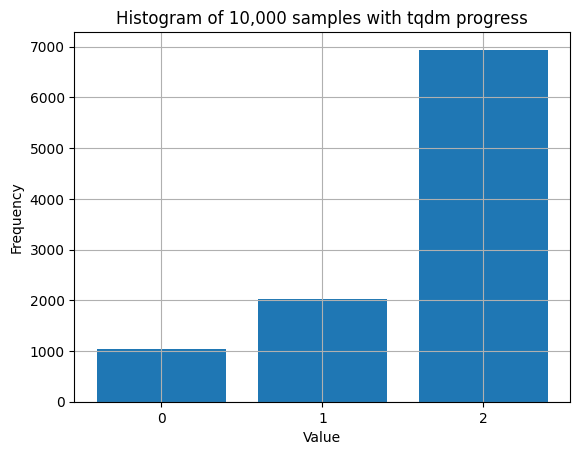

In [11]:
# Sample 10,000 values using tqdm
n_samples = 10000
dist = [0.1, 0.2, 0.7]
samples = my_sampler(n_samples, dist).numpy()

# Plot histogram
plt.hist(samples, bins=[-0.5, 0.5, 1.5, 2.5], rwidth=0.8, align='mid')
plt.xticks([0, 1, 2])
plt.xlabel("Value")
plt.ylabel("Frequency")
plt.title("Histogram of 10,000 samples with tqdm progress")
plt.grid(True)
plt.show()

This visual representation helps confirm that the function samples values according to the specified probabilities.

## Implement Autograd System

The task is to implement a custom scalar automatic differentiation system in Python, similar to PyTorch’s autograd system for scalar values.

The system should support forward computation of scalar operations such as exponentiation, logarithm, trigonometric functions, addition, multiplication, division, and power. It should also enable computing gradients via a backward pass through the computation graph.

### Class Implementation

The `MyScalar` class stores a value, its gradient, and a reference to the scalar(s) used to create it. A backward pass is used to compute gradients by recursively traversing the computation graph.

In [12]:
class MyScalar:
    """
    This class represents a scalar value that supports autograd functionality.

    Attributes:
        value (float): The actual scalar value.
        grad_wrt_parent (float): The immediate gradient with respect to the parent node.
        parent (Optional[MyScalar]): The previous node in the computational graph.
    """
    def __init__(self, value: float, grad: float = 1.0, parent: Optional['MyScalar'] = None) -> None:
        self.value = value           # A scalar value
        self.grad_wrt_parent = grad  # The immediate derivative at this node
        self.parent = parent         # The previous scalar used to create this one

    def __repr__(self) -> str:
        name = self.__class__.__name__
        attributes = ', '.join(f"{k}={v}" for k, v in self.__dict__.items())
        return f"{name}({attributes})"

### Math Library Function Implementations

#### Exponential operation

In [13]:
def exp(a: MyScalar) -> MyScalar:
    """
    Computes e^a and tracks the gradient d/dx (e^x) = e^x.
    """
    value = math.exp(a.value)
    grad = value
    return MyScalar(value, grad, parent=a)

Sanity test for `exp`

In [14]:
assert exp(MyScalar(1.0)).value == math.exp(1.0), "Test failed"

#### Logarithm operation

In [15]:
def ln(a: MyScalar) -> MyScalar:
    """
    Computes ln(a) and tracks the gradient d/dx (ln(x)) = 1/x.
    """
    assert a.value > 0, "ln is undefined for non-positive values"
    value = math.log(a.value)
    grad = 1 / a.value
    return MyScalar(value, grad, parent=a)

Sanity test for `ln`

In [16]:
assert ln(MyScalar(2.0)).value == math.log(2.0), "Test failed"

#### Sine operation

In [17]:
def sin(a: MyScalar) -> MyScalar:
    """
    Computes sin(a) and tracks the gradient d/dx (sin(x)) = cos(x).
    """
    value = math.sin(a.value)
    grad = math.cos(a.value)
    return MyScalar(value, grad, parent=a)

Sanity test for `sin`

In [18]:
assert sin(MyScalar(1.0)).value == math.sin(1.0), "Test failed"

#### Cosine operation

In [19]:
def cos(a: MyScalar) -> MyScalar:
    """
    Computes cos(a) and tracks the gradient d/dx (cos(x)) = -sin(x).
    """
    value = math.cos(a.value)
    grad = -math.sin(a.value)
    return MyScalar(value, grad, parent=a)

Sanity test for `cos`

In [20]:
assert cos(MyScalar(1.0)).value == math.cos(1.0), "Test failed"

#### Power operation: `a^n`

In [21]:
def power(a: MyScalar, n: float) -> MyScalar:
    """
    Computes a^n and tracks the gradient d/dx (x^n) = n * x^(n - 1).
    """
    value = math.pow(a.value, n)
    grad = n * math.pow(a.value, n - 1)
    return MyScalar(value, grad, parent=a)

Sanity test for `power`

In [22]:
result = power(MyScalar(2.0), 3.0)
assert result.value == math.pow(2.0, 3.0), "Test failed"
assert result.grad_wrt_parent == 3 * math.pow(2.0, 2.0), "Test failed"

#### Adding a constant

In [23]:
def add_const(a: MyScalar, c: float) -> MyScalar:
    """
    Adds a constant to a scalar value and tracks the gradient: d/dx (x + c) = 1
    """
    value = a.value + c
    grad = 1.0
    return MyScalar(value, grad, parent=a)

Sanity test for `add_const`

In [24]:
result = add_const(MyScalar(2.0), 3.0)
assert result.value == 5.0, "Test failed for value"
assert result.grad_wrt_parent == 1.0, "Test failed for gradient"

#### Multiplying by a constant

In [25]:
def multiply_const(a: MyScalar, c: float) -> MyScalar:
    """
    Multiplies scalar with constant and tracks the gradient d/dx (c * x) = c
    """
    value = a.value * c
    grad = c
    return MyScalar(value, grad, parent=a)

Sanity test for `multiply_const`

In [26]:
result = multiply_const(MyScalar(2.0), 3.0)
assert result.value == 6.0, "Test failed for value"
assert result.grad_wrt_parent == 3.0, "Test failed for gradient"

### Implement `get_gradient` function

#### Function definition

The `get_gradient` function performs reverse automatic differentiation on a computation graph of MyScalar objects. Given a final output scalar, it recursively computes the gradient of this output with respect to all input scalars involved in its computation.

Step-by-step explanation:

1. The function initializes an empty dictionary to store the accumulated gradients of each node (`scalar`) in the graph.

2. The function defines an inner function called `_backward` that:
 * Adds the incoming gradient (`grad`) to the current node’s total gradient.
 * Computes the gradient with respect to the parent node using the local derivative (`grad_wrt_parent`).
 * Recursively calls itself on the parent node.

**Note:** The backward process starts from the final node (scaler) with path_grad = 1.0, assuming we want dy/dy = 1.



In [27]:
def get_gradient(scaler: MyScalar) -> Dict[MyScalar, float]:
    """
    This function computes gradients of a scalar with respect to all input scalars in the computation graph.
    It performs reverse automatic differentiation starting from the given scalar node, and traverses back through the
    graph to accumulate gradients for each contributing node.

    Args:
        scaler (MyScalar): The scalar for which gradients are to be computed.

    Returns:
        Dict[MyScalar, float]: A dict mapping each scalar to its gradient with respect to the output.
    """
    gradients = dict()

    def _backward(node: MyScalar, grad: float) -> None:
        # Accumulate the gradient from this path into the total gradient at this node
        if node in gradients:
            gradients[node] += grad
        else:
            gradients[node] = grad

        # If this node has a parent, continue propagating the gradient
        if node.parent is not None:
            parent_grad = grad * node.grad_wrt_parent  # Apply the chain rule
            _backward(node.parent, parent_grad)

    _backward(scaler, 1.0)  # Start the backpropagation from the output node with gradient 1.0 (assuming dy/dy = 1)
    return gradients

### Tests

To verify correctness, the gradients from the custom autograd system are compared with PyTorch’s autograd system on the same computations.

#### Tolerance constant for floating-point comparison

In [28]:
EPSILON = 1e-5  # Tolerance for numerical comparison

#### Compare usage example to PyTorch autograd system

##### Test 1: Given usage example

In [29]:
a = MyScalar(2)
b = power(a, 2)
c = exp(b)
d = grads = get_gradient(c)

for var in [a, b, c]:
    print(var, end="\n\n")

for var, grad in grads.items():
    print(f"Gradient of {var} with respect to c: {grad}")

MyScalar(value=2, grad_wrt_parent=1.0, parent=None)

MyScalar(value=4.0, grad_wrt_parent=4.0, parent=MyScalar(value=2, grad_wrt_parent=1.0, parent=None))

MyScalar(value=54.598150033144236, grad_wrt_parent=54.598150033144236, parent=MyScalar(value=4.0, grad_wrt_parent=4.0, parent=MyScalar(value=2, grad_wrt_parent=1.0, parent=None)))

Gradient of MyScalar(value=54.598150033144236, grad_wrt_parent=54.598150033144236, parent=MyScalar(value=4.0, grad_wrt_parent=4.0, parent=MyScalar(value=2, grad_wrt_parent=1.0, parent=None))) with respect to c: 1.0
Gradient of MyScalar(value=4.0, grad_wrt_parent=4.0, parent=MyScalar(value=2, grad_wrt_parent=1.0, parent=None)) with respect to c: 54.598150033144236
Gradient of MyScalar(value=2, grad_wrt_parent=1.0, parent=None) with respect to c: 218.39260013257694


##### Perform the same operations using PyTorch

In [30]:
a_torch = torch.tensor(2.0, requires_grad=True)
b_torch = a_torch ** 2
b_torch.retain_grad()
c_torch = torch.exp(b_torch)
c_torch.backward()

##### Validate the results

In [31]:
assert abs(grads[a] - a_torch.grad.item()) < EPSILON, "Test 1 failed: gradient of a does not match PyTorch"
assert abs(grads[b] - b_torch.grad.item()) < EPSILON, "Test 1 failed: gradient of b does not match PyTorch"
print("✅ Test passed")

✅ Test passed


#### Test 2: `y = exp(x^2)`

In [32]:
x = MyScalar(1.0)
y = exp(power(x, 2))
grad = get_gradient(y)[x]

x_torch = torch.tensor(1.0, requires_grad=True)
y_torch = torch.exp(torch.pow(x_torch, 2))
y_torch.backward()

assert abs(y.value - y_torch.item()) < EPSILON, f"Test 2 failed: y value mismatch. Expected {y_t.item()}, got {y.value}"
assert abs(grad - x_torch.grad.item()) < EPSILON, f"Test 2 failed: gradient mismatch. Expected {x_t.grad.item()}, got {grad}"
print("✅ Test passed")

✅ Test passed


##### Test 3: `y = ln(x)`

In [33]:
x = MyScalar(2.0)
y = ln(x)
grad = get_gradient(y)[x]

x_torch = torch.tensor(2.0, requires_grad=True)
y_torch = torch.log(x_torch)
y_torch.backward()

assert abs(y.value - y_torch.item()) < EPSILON, f"Test 3 failed: y value mismatch. Expected {y_t.item()}, got {y.value}"
assert abs(grad - x_torch.grad.item()) < EPSILON, f"Test 3 failed: gradient mismatch. Expected {x_t.grad.item()}, got {grad}"
print("✅ Test passed")

✅ Test passed


##### Test 4: `y = sin(x)`

In [34]:
x = MyScalar(0.5)
y = sin(x)
grad = get_gradient(y)[x]

x_torch = torch.tensor(0.5, requires_grad=True)
y_torch = torch.sin(x_torch)
y_torch.backward()

assert abs(y.value - y_torch.item()) < EPSILON, f"Test 4 failed: y value mismatch. Expected {y_t.item()}, got {y.value}"
assert abs(grad - x_torch.grad.item()) < EPSILON, f"Test 4 failed: gradient mismatch. Expected {x_t.grad.item()}, got {grad}"
print("✅ Test passed")

✅ Test passed


##### Test 5: `y = cos(x)`

In [35]:
x = MyScalar(0.5)
y = cos(x)
grad = get_gradient(y)[x]

x_torch = torch.tensor(0.5, requires_grad=True)
y_torch = torch.cos(x_torch)
y_torch.backward()

assert abs(y.value - y_torch.item()) < EPSILON, f"Test 5 failed: y value mismatch. Expected {y_t.item()}, got {y.value}"
assert abs(grad - x_torch.grad.item()) < EPSILON, f"Test 5 failed: gradient mismatch. Expected {x_t.grad.item()}, got {grad}"
print("✅ Test passed")

✅ Test passed


##### Test 6: `y = 3 * sin(x)`

In [36]:
x = MyScalar(0.8)
y = multiply_const(sin(x), 3.0)
grad = get_gradient(y)[x]

x_torch = torch.tensor(0.8, requires_grad=True)
y_torch = 3 * torch.sin(x_torch)
y_torch.backward()

assert abs(y.value - y_torch.item()) < EPSILON, f"Test 5 failed: y value mismatch. Expected {y_t.item()}, got {y.value}"
assert abs(grad - x_torch.grad.item()) < EPSILON, f"Test 5 failed: gradient mismatch. Expected {x_t.grad.item()}, got {grad}"
print("✅ Test passed")

✅ Test passed


##### Test 7: `y = x^n` for float n

In [37]:
x = MyScalar(3.0)
y = power(x, 4.0)
grad = get_gradient(y)[x]

x_torch = torch.tensor(3.0, requires_grad=True)
y_torch = torch.pow(x_torch, 4.0)
y_torch.backward()

assert abs(y.value - y_torch.item()) < EPSILON, f"Test 6 failed: y value mismatch. Expected {y_t.item()}, got {y.value}"
assert abs(grad - x_torch.grad.item()) < EPSILON, f"Test 6 failed: gradient mismatch. Expected {x_t.grad.item()}, got {grad}"
print("✅ Test passed")

✅ Test passed


## Bonus - Extend Autograd System to 2 Inputs

### Class Definition

In this section, we extend the automatic differentiation system described earlier to handle operations with two inputs, such as addition, multiplication, and division. To do this, we use inheritance to build upon the custom scalar class `MyScalar` and introduce a new class, `MyScalar2Inputs`, which is specifically designed to handle operations involving two parent nodes.

In [38]:
class MyScalar2Inputs(MyScalar):
    """
    This class represents a scalar value that depends on two parent scalars.

    Args:
        value (float): The resulting scalar value of the operation.
        parent (MyScalar): The first parent node in the computation graph.
        parent2 (MyScalar): The second parent node in the computation graph.
        grad_wrt_parent (float): The gradient with respect to the first parent.
        grad_wrt_parent2 (float): The gradient with respect to the second parent.
    """
    def __init__(self, value: float, parent: MyScalar, parent2: MyScalar, grad_wrt_parent: float,
                 grad_wrt_parent2: float) -> None:
        super().__init__(value=value, grad=grad_wrt_parent, parent=parent)
        self.parent2 = parent2
        self.grad_wrt_parent2 = grad_wrt_parent2

The `__init__` function initializes these values by calling the parent class `MyScalar` constructor, and adding the `parent2` and `grad_wrt_parent2` attributes.

### Define Mathematical Operations for Two Variables

#### Adding two `MyScalar` objects together

This function computes the value as `a.value + b.value`, and returns an instance of `MyScalar2Inputs` where `parent` is `a`, `parent2` is `b.`

Gradients with respect to a and b are both set to 1.0, as the derivative of a sum with respect to each variable is 1.

In [39]:
def add(a: MyScalar, b: MyScalar) -> MyScalar2Inputs:
    value = a.value + b.value
    return MyScalar2Inputs(value, a, b, 1.0, 1.0)

Sanity test for `add`

In [40]:
result = add(MyScalar(2.0), MyScalar(3.0))
assert result.value == 5.0, "Test failed: add function value mismatch"
assert result.grad_wrt_parent == 1.0 and result.grad_wrt_parent2 == 1.0, "Test failed: add function gradients mismatch"

#### Multiply two `MyScalar` objects together

This function computes the value as `a.value * b.value`, and the gradients as follows:

- `grad_wrt_parent = b.value` - derivative of `a * b` with respect to `a` is `b`.

- `grad_wrt_parent2 = a.value` - derivative of `a * b` with respect to `b` is `a`.

The function returns an instance of `MyScalar2Inputs` with the computed gradients.

In [41]:
def multiply(a: MyScalar, b: MyScalar) -> MyScalar2Inputs:
    value = a.value * b.value
    return MyScalar2Inputs(value, a, b, b.value, a.value)

Sanity test for `multiply`

In [42]:
result = multiply(MyScalar(2.0), MyScalar(3.0))
assert result.value == 6.0, "Test failed: multiply function value mismatch"
assert result.grad_wrt_parent == 3.0, "Test failed: multiply function gradients mismatch"
assert result.grad_wrt_parent2 == 2.0, "Test failed: multiply function gradients mismatch"

#### Divide `MyScalar` by another `MyScalar`

This function divides `a` by `b`. The value is calculated as `a.value / b.value`, and the gradients are:

- `grad_wrt_parent = -a.value / (b.value^2)` - derivative of `a / b` with respect to `a`.

- `grad_wrt_parent2 = 1 / b.value` - derivative of `a / b` with respect to `b`).

These gradients are returned as part of a `MyScalar2Inputs` object.

In [43]:
def divide(a: MyScalar, b: MyScalar) -> MyScalar2Inputs:
    value = a.value / b.value
    grad_wrt_a = 1.0 / b.value
    grad_wrt_b = -a.value / (b.value ** 2)
    return MyScalar2Inputs(value, a, b, grad_wrt_a, grad_wrt_b)

Sanity test for `divide`

In [44]:
result = divide(MyScalar(6.0), MyScalar(3.0))
assert result.value == 2.0, "Test failed: divide function value mismatch"
assert result.grad_wrt_parent == 1.0 / 3.0, "Test failed: divide function gradients mismatch"
assert result.grad_wrt_parent2 == -6.0 / 9.0, "Test failed: divide function gradients mismatch"

### Extend `get_gradient` to `MyScaler2Inputs`

This function performs backpropagation to compute the gradients of all the parents of a given scaler.

It uses a recursive helper inner function `_backprop` that traverses the computational graph, starting from the given `scaler`.

If the current node (`scalar`) has a parent, the function propagates the gradient backward through the graph using the chain rule. If the node is a `MyScalar2Inputs` object, it computes gradients for the second parent as well and propagates it accordingly.

The function accumulates the gradients in a dictionary and returns it.

In [45]:
def get_gradient(scaler: MyScalar) -> Dict[MyScalar, float]:
    """
    This function computes gradients of a scalar with respect to all input scalars in the computation graph.
    It performs reverse automatic differentiation starting from the given scalar node, and traverses back through the
    graph to accumulate gradients for each contributing node.

    Args:
        scaler (MyScalar): The scalar for which gradients are to be computed.

    Returns:
        Dict[MyScalar, float]: A dict mapping each scalar to its gradient with respect to the output.
    """
    gradients = dict()

    def _backprop(node: MyScalar, grad: float) -> None:
        if node in gradients:
            gradients[node] += grad
        else:
            gradients[node] = grad

        if getattr(node, 'parent', None) is not None:
            _backprop(node.parent, grad * node.grad_wrt_parent)
        if getattr(node, 'parent2', None) is not None:
            _backprop(node.parent2, grad * node.grad_wrt_parent2)

    _backprop(scaler, 1.0)
    return gradients


Note that this function implementation can replace the previous one, as it fully supports a `MyScalar` with a single parent.

### Test

#### Custom autograd system usage example

In [46]:
a = MyScalar(3.0)
b = MyScalar(4.0)
c = multiply(a, b)
d = add(c, a)
e = divide(c, a)
grads = get_gradient(e)

for var in [a, b, c, d, e]:
    print(var, end="\n\n")

for var, grad in grads.items():
    print(f"Gradient of {var} with respect to d: {grad}")

MyScalar(value=3.0, grad_wrt_parent=1.0, parent=None)

MyScalar(value=4.0, grad_wrt_parent=1.0, parent=None)

MyScalar2Inputs(value=12.0, grad_wrt_parent=4.0, parent=MyScalar(value=3.0, grad_wrt_parent=1.0, parent=None), parent2=MyScalar(value=4.0, grad_wrt_parent=1.0, parent=None), grad_wrt_parent2=3.0)

MyScalar2Inputs(value=15.0, grad_wrt_parent=1.0, parent=MyScalar2Inputs(value=12.0, grad_wrt_parent=4.0, parent=MyScalar(value=3.0, grad_wrt_parent=1.0, parent=None), parent2=MyScalar(value=4.0, grad_wrt_parent=1.0, parent=None), grad_wrt_parent2=3.0), parent2=MyScalar(value=3.0, grad_wrt_parent=1.0, parent=None), grad_wrt_parent2=1.0)

MyScalar2Inputs(value=4.0, grad_wrt_parent=0.3333333333333333, parent=MyScalar2Inputs(value=12.0, grad_wrt_parent=4.0, parent=MyScalar(value=3.0, grad_wrt_parent=1.0, parent=None), parent2=MyScalar(value=4.0, grad_wrt_parent=1.0, parent=None), grad_wrt_parent2=3.0), parent2=MyScalar(value=3.0, grad_wrt_parent=1.0, parent=None), grad_wrt_parent2=-1.3333

##### Perform the same operations using PyTorch

In [47]:
a_torch = torch.tensor(3.0, requires_grad=True)
b_torch = torch.tensor(4.0, requires_grad=True)
c_torch = a_torch * b_torch
d_torch = c_torch + a_torch
e_torch = c_torch / a_torch
e_torch.backward()

##### Validate the results

Assertions for values

In [48]:
assert c.value == c_torch.item(), f"Expected c={c_torch.item()}, got {c.value}"
assert d.value == d_torch.item(), f"Expected d={d_torch.item()}, got {d.value}"
assert e.value == e_torch.item(), f"Expected e={e_torch.item()}, got {e.value}"
print("✅ Tests passed!")

✅ Tests passed!


Assertions for gradients


In [49]:
assert grads[a] == a_torch.grad.item(), f"Expected grad_a={a_torch.grad.item()}, got {grads[a]}"
assert grads[b] == b_torch.grad.item(), f"Expected grad_b={b_torch.grad.item()}, got {grads[b]}"
print("✅ Tests passed!")

✅ Tests passed!
